# Monk Notebook

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.network import NeuralNetwork
from model.trainer import Trainer
from model.losses import Loss
from utils import DataLoader
from utils import load_monk, plot_curves
from model.activations import sigmoid

np.random.seed(8) # for reproducibility, we are not choosing a 'good seed for rigging experiments', just my lucky number =)

In [2]:
# All the configurations to test for the training
# Neural Network architectures
INPUT_NEURONS = 17
OUTPUT_NEURONS = 1

HIDDEN_LAYER_SIZES = [4, 8]
HIDDEN_LAYERS_COUNTS = [1, 2]
INTERNAL_ACTIVATIONS = ['tanh', 'leaky relu', 'relu']
OUTPUT_ACTIVATIONS_AND_LOSS = [('sigmoid', 'mse'), ('identity', 'binary cross entropy sigmoid')]
NEURAL_NETWORK_CONFIGURATIONS = []

for hidden_layers_count in HIDDEN_LAYERS_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for internal_activation in INTERNAL_ACTIVATIONS:
            for output_activation, loss_function in OUTPUT_ACTIVATIONS_AND_LOSS:
                architecture = [INPUT_NEURONS] + [hidden_layer_size] * hidden_layers_count + [OUTPUT_NEURONS]
                activations = [internal_activation] * hidden_layers_count + [output_activation]
                NEURAL_NETWORK_CONFIGURATIONS.append((architecture, activations, loss_function))

# Training parameters
ETA_CONFIGURATIONS = [0.01, 0.001]
LAMBDA_CONFIGURATIONS = [0, 1e-3, 1e-4]
ALPHA_CONFIGURATIONS = [0, 0.5, 0.9]
BATCH_SIZES = [16, 32]

# Cross-validation parameters
K_FOLDS= 5
EPOCHS = 250
EARLY_STOPPING_PATIENCE = 50

# All possible configurations are tuples (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
CONFIGURATIONS = []

for NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F in NEURAL_NETWORK_CONFIGURATIONS:
  for ETA in ETA_CONFIGURATIONS:
    for LAMBDA in LAMBDA_CONFIGURATIONS:
      for ALPHA in ALPHA_CONFIGURATIONS:
        for BATCH_SIZE in BATCH_SIZES:
            config = (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
            CONFIGURATIONS.append(config)
LEN_CONFIGURATIONS = len(CONFIGURATIONS)

#helper function to count params that we will use later, since often we will get 100% acc, we chose the config with less parameters
def count_parameters(architecture):
    tot_params = 0
    for i in range(len(architecture) - 1):
        tot_params += architecture[i] * architecture[i+1] + architecture[i+1] # weights and bias
    return tot_params

## Monk 1

In [3]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-1.train'
PATH_TEST = 'data/monk/monks-1.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_1 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_1.k_fold(k = K_FOLDS)

# Here we create dictionaries for storing avg accuracies and epochs on k folds, we will use them to select the best configuration
CONFIG_DICTIONARY = {}
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY[i] = 0

CONFIG_DICTIONARY_EPOCHS = {}
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY_EPOCHS[i] = 0

# Cross Validation X K-folds
for i in range(LEN_CONFIGURATIONS): #iterate over all configurations
  print(f"Training {i+1}/{LEN_CONFIGURATIONS}")
  config = CONFIGURATIONS[i]
  
  for X_train, y_train, X_val, y_val in k_fold: #iterate over k folds
    NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = config
    print(f"NEURAL_NETWORK_ARCHITECTURE: {NEURAL_NETWORK_ARCHITECTURE}, NEURAL_NETWORK_ACTIVATION: {NEURAL_NETWORK_ACTIVATION}, LOSS_F: {LOSS_F}, ETA: {ETA}, LAMBDA: {LAMBDA}, ALPHA: {ALPHA}, BATCH_SIZE: {BATCH_SIZE}")
    
    #train
    nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
    trainer = Trainer(
        nn=nn,
        loss=Loss(LOSS_F),
        X_train=X_train,
        y_train=y_train, 
        X_val=X_val,
        y_val=y_val,
        epochs=EPOCHS,
        early_stopping=EARLY_STOPPING_PATIENCE, # no improvements in 50 epochs-> stop
        eta=ETA,                   # Learning rate iniziale
        lam=LAMBDA,                # L2
        alpha=ALPHA,               # Momentum
        batch_size=BATCH_SIZE,
        shuffle_batches=True
    )
    best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False) # returns the best nn based on val, the train and val loss vectors
    CONFIG_DICTIONARY_EPOCHS[i] += len(train_loss_vector) #number of epochs until early stopping or max epochs
    
    #best val accuracy
    out = best_nn.forward(X_val)[-1][-1]
    if LOSS_F == 'binary cross entropy sigmoid':
      out = sigmoid(out)
    predictions = np.round(out)
    print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
    CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)

After one-hot encoding: X train full shape: (124, 17), X test shape: (432, 17), y train full shape: (124, 1), y test shape: (432, 1)
Training 1/864
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 76.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 84.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 70.83333333333334%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 88.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 96.0%
Training 2/864

Top 5 configurations:
Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.0001, 0.9, 16), Avg Epochs: 185, Mean Accuracy: 100.0%
Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.0001, 0.9, 32), Avg Epochs: 200, Mean Accuracy: 100.0%
Config index: ([17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.0001, 0.9, 16), Avg Epochs: 202, Mean Accuracy: 100.0%
Config index: ([17, 4, 1], ['leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.0001, 0.9, 16), Avg Epochs: 232, Mean Accuracy: 100.0%
Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.9, 32), Avg Epochs: 250, Mean Accuracy: 100.0%


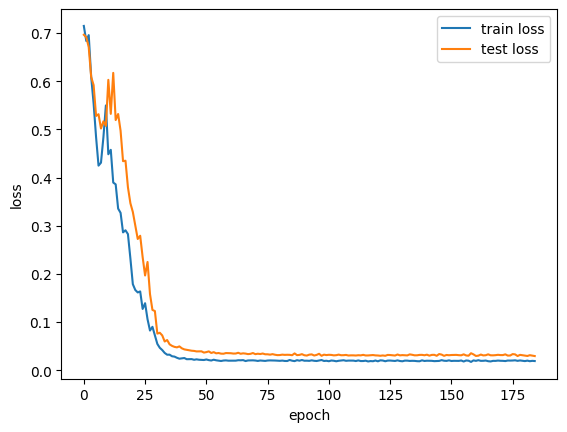

Accuracy: 100.0%


In [4]:
# print the top 5 configurations, sorting criterias: 1 avg accuracy, 2 n parameters (the less the better), 3 epochs trained (the less the better)
TOP_5_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=lambda i: (-CONFIG_DICTIONARY[i], count_parameters(CONFIGURATIONS[i][0]), CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS))[:5]
print("Top 5 configurations:")
for i in TOP_5_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / K_FOLDS
    print(f"Config index: {CONFIGURATIONS[i]}, Avg Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}, Mean Accuracy: {ACCURACY}%")

# Get the best configuration and its average epochs + early stop epochs to be sure it converges
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = CONFIGURATIONS[TOP_5_CONFIGS_INDEXES[0]]
EPOCHS = CONFIG_DICTIONARY_EPOCHS[TOP_5_CONFIGS_INDEXES[0]] // K_FOLDS

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss', 'test')

# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Accuracy: {np.mean(predictions == y_test) * 100}%")

## Monk 2

In [5]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-2.train'
PATH_TEST = 'data/monk/monks-2.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_2 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_2.k_fold(k = K_FOLDS)

# Here we create dictionaries for storing avg accuracies and epochs on k folds, we will use them to select the best configuration
CONFIG_DICTIONARY = {}
LEN_CONFIGURATIONS = len(CONFIGURATIONS)
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY[i] = 0

CONFIG_DICTIONARY_EPOCHS = {}
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY_EPOCHS[i] = 0

# Cross Validation X K-folds
for i in range(LEN_CONFIGURATIONS): #iterate over all configurations
  print(f"Training {i+1}/{LEN_CONFIGURATIONS}")
  config = CONFIGURATIONS[i]
  
  for X_train, y_train, X_val, y_val in k_fold: #iterate over k folds
    NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = config
    print(f"NEURAL_NETWORK_ARCHITECTURE: {NEURAL_NETWORK_ARCHITECTURE}, NEURAL_NETWORK_ACTIVATION: {NEURAL_NETWORK_ACTIVATION}, LOSS_F: {LOSS_F}, ETA: {ETA}, LAMBDA: {LAMBDA}, ALPHA: {ALPHA}, BATCH_SIZE: {BATCH_SIZE}")
    
    #train
    nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
    trainer = Trainer(
        nn=nn,
        loss=Loss(LOSS_F),
        X_train=X_train,
        y_train=y_train, 
        X_val=X_val,
        y_val=y_val,
        epochs=EPOCHS,
        early_stopping=EARLY_STOPPING_PATIENCE, # no improvements in 50 epochs-> stop
        eta=ETA,                   # Learning rate iniziale
        lam=LAMBDA,                # L2
        alpha=ALPHA,               # Momentum
        batch_size=BATCH_SIZE,
        shuffle_batches=True
    )
    best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False) # returns the best nn based on val, the train and val loss vectors
    CONFIG_DICTIONARY_EPOCHS[i] += len(train_loss_vector) #number of epochs until early stopping or max epochs
    
    #best val accuracy
    out = best_nn.forward(X_val)[-1][-1]
    if LOSS_F == 'binary cross entropy sigmoid':
      out = sigmoid(out)
    predictions = np.round(out)
    print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
    CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)

After one-hot encoding: X train full shape: (169, 17), X test shape: (432, 17), y train full shape: (169, 1), y test shape: (432, 1)
Training 1/864
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 50.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 61.76470588235294%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 87.87878787878788%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 47.05882352941176%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accu

Top 5 configurations:
Config index: ([17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.9, 32), Avg Epochs: 80, Mean Accuracy: 100.0%
Config index: ([17, 4, 1], ['leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.9, 32), Avg Epochs: 82, Mean Accuracy: 100.0%
Config index: ([17, 4, 1], ['relu', 'sigmoid'], 'mse', 0.01, 0.001, 0.9, 32), Avg Epochs: 110, Mean Accuracy: 100.0%
Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.9, 32), Avg Epochs: 131, Mean Accuracy: 100.0%
Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.9, 16), Avg Epochs: 139, Mean Accuracy: 100.0%


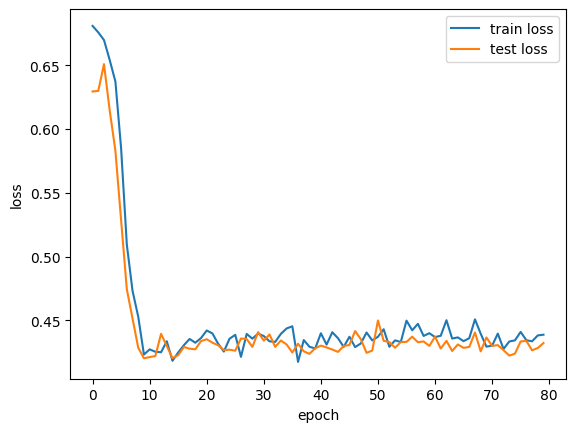

Accuracy: 73.14814814814815%


In [6]:
# print the top 5 configurations, sorting criterias: 1 avg accuracy, 2 n parameters (the less the better), 3 epochs trained (the less the better)
TOP_5_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=lambda i: (-CONFIG_DICTIONARY[i], count_parameters(CONFIGURATIONS[i][0]), CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS))[:5]
print("Top 5 configurations:")
for i in TOP_5_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / K_FOLDS
    print(f"Config index: {CONFIGURATIONS[i]}, Avg Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}, Mean Accuracy: {ACCURACY}%")

# Get the best configuration and its average epochs + early stop epochs to be sure it converges
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = CONFIGURATIONS[TOP_5_CONFIGS_INDEXES[0]]
EPOCHS = CONFIG_DICTIONARY_EPOCHS[TOP_5_CONFIGS_INDEXES[0]] // K_FOLDS

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss', 'test')

# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Accuracy: {np.mean(predictions == y_test) * 100}%")

## Monk 3

In [7]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-3.train'
PATH_TEST = 'data/monk/monks-3.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_3 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_3.k_fold(k = K_FOLDS)

# Here we create dictionaries for storing avg accuracies and epochs on k folds, we will use them to select the best configuration
CONFIG_DICTIONARY = {}
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY[i] = 0

CONFIG_DICTIONARY_EPOCHS = {}
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY_EPOCHS[i] = 0

# Cross Validation X K-folds
for i in range(LEN_CONFIGURATIONS): #iterate over all configurations
  print(f"Training {i+1}/{LEN_CONFIGURATIONS}")
  config = CONFIGURATIONS[i]
  
  for X_train, y_train, X_val, y_val in k_fold: #iterate over k folds
    NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = config
    print(f"NEURAL_NETWORK_ARCHITECTURE: {NEURAL_NETWORK_ARCHITECTURE}, NEURAL_NETWORK_ACTIVATION: {NEURAL_NETWORK_ACTIVATION}, LOSS_F: {LOSS_F}, ETA: {ETA}, LAMBDA: {LAMBDA}, ALPHA: {ALPHA}, BATCH_SIZE: {BATCH_SIZE}")
    
    #train
    nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
    trainer = Trainer(
        nn=nn,
        loss=Loss(LOSS_F),
        X_train=X_train,
        y_train=y_train, 
        X_val=X_val,
        y_val=y_val,
        epochs=EPOCHS,
        early_stopping=EARLY_STOPPING_PATIENCE, # no improvements in 50 epochs-> stop
        eta=ETA,                   # Learning rate iniziale
        lam=LAMBDA,                # L2
        alpha=ALPHA,               # Momentum
        batch_size=BATCH_SIZE,
        shuffle_batches=True
    )
    best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False) # returns the best nn based on val, the train and val loss vectors
    CONFIG_DICTIONARY_EPOCHS[i] += len(train_loss_vector) #number of epochs until early stopping or max epochs
    
    #best val accuracy
    out = best_nn.forward(X_val)[-1][-1]
    if LOSS_F == 'binary cross entropy sigmoid':
      out = sigmoid(out)
    predictions = np.round(out)
    print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
    CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)

After one-hot encoding: X train full shape: (122, 17), X test shape: (432, 17), y train full shape: (122, 1), y test shape: (432, 1)
Training 1/864
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 92.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 91.66666666666666%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 88.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 95.83333333333334%


In [8]:
# print the top 10 configurations, sorting criterias: 1 avg accuracy, 2 n parameters (the less the better), 3 epochs trained (the less the better)
TOP_10_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=lambda i: (-CONFIG_DICTIONARY[i], count_parameters(CONFIGURATIONS[i][0]), CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS))[:10]
print("Top 10 configurations:")
for i in TOP_10_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / K_FOLDS
    print(f"Config index: {CONFIGURATIONS[i]}, Avg Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}, Mean Accuracy: {ACCURACY}%")

Top 10 configurations:
Config index: ([17, 8, 8, 1], ['relu', 'relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.5, 16), Avg Epochs: 73, Mean Accuracy: 95.96666666666667%
Config index: ([17, 4, 4, 1], ['relu', 'relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.9, 32), Avg Epochs: 74, Mean Accuracy: 95.16666666666666%
Config index: ([17, 8, 8, 1], ['tanh', 'tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.5, 16), Avg Epochs: 74, Mean Accuracy: 95.16666666666666%
Config index: ([17, 4, 1], ['leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.0001, 0.9, 32), Avg Epochs: 64, Mean Accuracy: 95.13333333333334%
Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.9, 32), Avg Epochs: 70, Mean Accuracy: 95.13333333333334%
Config index: ([17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.9, 32), Avg Epochs: 70, Mean Accuracy: 95.13333333333334%
Config index: ([17, 4

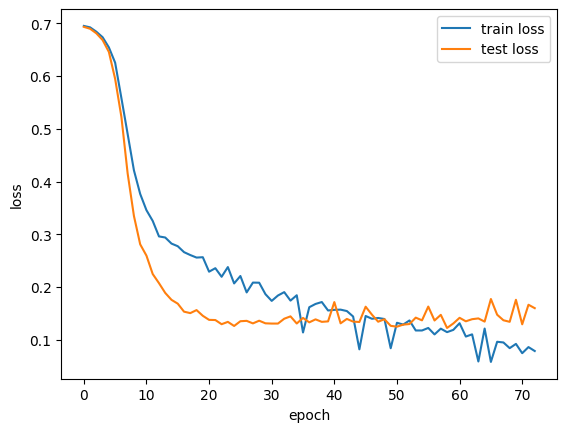

Accuracy: 93.51851851851852%


In [13]:
# Get the best configuration and its average epochs + early stop epochs to be sure it converges
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = CONFIGURATIONS[TOP_10_CONFIGS_INDEXES[0]]
EPOCHS = CONFIG_DICTIONARY_EPOCHS[TOP_10_CONFIGS_INDEXES[0]] // K_FOLDS

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss', 'test')

# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Accuracy: {np.mean(predictions == y_test) * 100}%")